/Users/alihamedi/mambaforge/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode: 0, Total Reward: 0.7599999999999999
Episode: 1, Total Reward: -1.35
Episode: 2, Total Reward: -1.08
Episode: 3, Total Reward: -1.33
Episode: 4, Total Reward: -1.08
Episode: 5, Total Reward: -1.4000000000000001
Episode: 6, Total Reward: -1.16
Episode: 7, Total Reward: -1.04
Episode: 8, Total Reward: -1.21
Episode: 9, Total Reward: -1.29
Episode: 10, Total Reward: -1.16
Episode: 11, Total Reward: -1.07
Episode: 12, Total Reward: -1.1
Episode: 13, Total Reward: 0.82
Episode: 14, Total Reward: -1.8100000000000005
Episode: 15, Total Reward: 0.88
Episode: 16, Total Reward: -1.27
Episode: 17, Total Reward: -1.2
Episode: 18, Total Reward: -1.32
Episode: 19, Total Reward: -1.1099999999999999
Episode: 20, Total Reward: 0.7699999999999999
Episode: 21, Total Reward: -1.09
Episode: 22, Total Reward: 0.92
Episode: 23, Total Reward: -1.08
Episode: 24, Total Reward: -1.05
Episode: 25, Total Reward: 0.92
Episode: 26, Total Reward: 0.73
Episode: 27, Total Reward: 0.9299999999999999
Episode: 28,

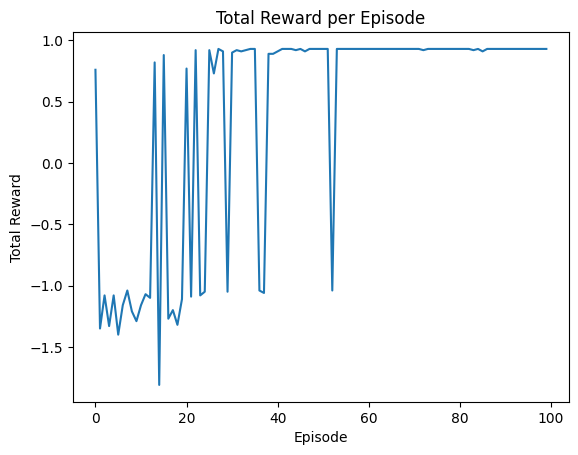

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# Define the GridWorld environment
class GridWorld:
    def __init__(self, size=5, traps=3):
        self.size = size
        self.state = (0, 0)
        self.goal = (size - 1, size - 1)
        self.traps = self._place_traps(traps)
        self.action_space = 2  # each option has 2 actions
        self.option_space = 2  # two options: horizontal and vertical
        self.state_size = size * size

    def _place_traps(self, num_traps):
        traps = set()
        while len(traps) < num_traps:
            trap = (random.randint(0, self.size-1), random.randint(0, self.size-1))
            if trap != self.state and trap != self.goal:
                traps.add(trap)
        return traps

    def reset(self):
        self.state = (0, 0)
        return self._get_state()

    def _get_state(self):
        state = np.zeros((self.size, self.size))
        state[self.state] = 1
        return state.flatten()

    def step(self, option, action):
        x, y = self.state
        if option == 0:  # horizontal movement
            if action == 0 and y > 0:  # left
                y -= 1
            elif action == 1 and y < self.size - 1:  # right
                y += 1
        elif option == 1:  # vertical movement
            if action == 0 and x > 0:  # up
                x -= 1
            elif action == 1 and x < self.size - 1:  # down
                x += 1

        self.state = (x, y)
        if self.state == self.goal:
            return self._get_state(), 1, True, {}
        elif self.state in self.traps:
            return self._get_state(), -1, True, {}
        else:
            return self._get_state(), -0.01, False, {}

    def render(self):
        grid = np.zeros((self.size, self.size), dtype=str)
        grid[:] = '.'
        grid[self.state] = 'A'
        for trap in self.traps:
            grid[trap] = 'T'
        grid[self.goal] = 'G'
        print("\n".join("".join(row) for row in grid))
        print()

# Hyperparameters
GAMMA = 0.99
LEARNING_RATE = 0.001
MAX_EPISODES = 100

# Option Network (for choosing options)
class OptionNet(nn.Module):
    def __init__(self, state_size, option_size):
        super(OptionNet, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, option_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Actor Network (for choosing actions within an option)
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Critic Network (for estimating state-value)
class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

env = GridWorld()
# Initialize networks and optimizers
state_size = env.state_size
option_size = env.option_space
action_size = env.action_space

option_net = OptionNet(state_size, option_size)
actor_horizontal = Actor(state_size, action_size)
actor_vertical = Actor(state_size, action_size)
critic = Critic(state_size)

option_optimizer = optim.Adam(option_net.parameters(), lr=LEARNING_RATE)
actor_optimizer_horizontal = optim.Adam(actor_horizontal.parameters(), lr=LEARNING_RATE)
actor_optimizer_vertical = optim.Adam(actor_vertical.parameters(), lr=LEARNING_RATE)
critic_optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# Training loop
history = []
for episode in range(MAX_EPISODES):
    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0)
    done = False
    total_reward = 0

    while not done:
        # Choose option
        option_probs = option_net(state)
        option_dist = torch.distributions.Categorical(option_probs)
        option = option_dist.sample().item()
        
        # Choose action based on the chosen option
        if option == 0:
            action_probs = actor_horizontal(state)
        else:
            action_probs = actor_vertical(state)
        
        action_dist = torch.distributions.Categorical(action_probs)
        action = action_dist.sample().item()
        
        # Take action in the environment
        next_state, reward, done, _ = env.step(option, action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        total_reward += reward

        # Predict the value of the current and next states using the critic network
        value = critic(state)
        next_value = critic(next_state)
        
        # Compute the target and advantage
        target = reward + (1 - done) * GAMMA * next_value.item()
        target = torch.tensor([target])
        advantage = target - value

        # Compute loss for option network
        option_loss = -option_dist.log_prob(torch.tensor(option)) * advantage
        
        # Compute loss for actor network
        if option == 0:
            actor_loss = -action_dist.log_prob(torch.tensor(action)) * advantage
        else:
            actor_loss = -action_dist.log_prob(torch.tensor(action)) * advantage
        
        # Compute loss for critic network
        critic_loss = criterion(value, target)

        # Update option network
        option_optimizer.zero_grad()
        option_loss.backward(retain_graph=True)
        option_optimizer.step()

        # Update actor network
        if option == 0:
            actor_optimizer_horizontal.zero_grad()
            actor_loss.backward(retain_graph=True)
            actor_optimizer_horizontal.step()
        else:
            actor_optimizer_vertical.zero_grad()
            actor_loss.backward(retain_graph=True)
            actor_optimizer_vertical.step()

        # Update critic network
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Transition to the next state
        state = next_state

    # Log episode results
    history.append(total_reward)
    print(f"Episode: {episode}, Total Reward: {total_reward}")

plt.plot(history)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

A....
.....
.T.T.
T....
....G

right
right
right
right
down
down
down
down
A....
.....
.T.T.
T....
....G

right
right
right
right
down
down
down
down


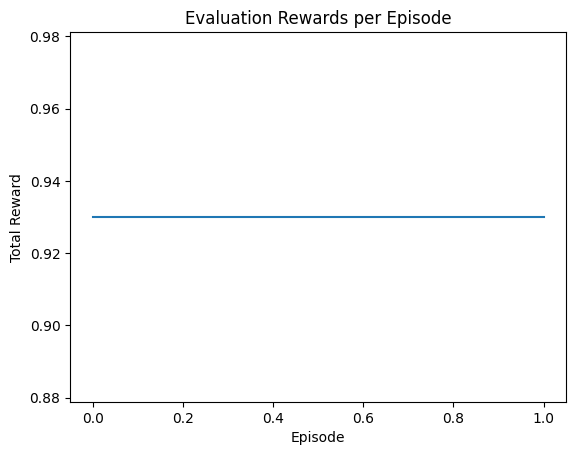

In [15]:
# Evaluation with rendering
eval_rewards = []
for _ in range(2):
    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0)
    done = False
    episode_reward = 0
    env.render() 
    while not done:

        # Choose option and action based on the learned policy
        option_probs = option_net(state)
        option = torch.argmax(option_probs).item()

        if option == 0:
            action_probs = actor_horizontal(state)
        else:
            action_probs = actor_vertical(state)
        
        action = torch.argmax(action_probs).item()
        
        # Take action in the environment
        next_state, reward, done, _ = env.step(option, action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        episode_reward += reward
        state = next_state

   # Render the final state of the environment
    eval_rewards.append(episode_reward)

# Plot evaluation rewards
plt.plot(eval_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Evaluation Rewards per Episode')
plt.show()
